<a href="https://colab.research.google.com/github/tjmj-uva/DLIP_project/blob/main/dannynet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DannyNet - Keras Edition

**Combining the best of both worlds:**
- ✅ DannyNet's improvements (Focal Loss, AdamW, patient-level splits, optimal thresholds)
- ✅ Keras's simplicity (auto-tracking, easy plotting, clean API)
- ✅ No TensorBoard headaches!

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve
import time

print("="*60)
print("DANNYNET - KERAS EDITION")
print("="*60)

# Configuration
CONFIG = {
    "model": "dannynet_keras",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 1,  # Change to 25 for full training
    "patience": 5,
    "seed": 42,
    "image_size": 224,
}

# Set seeds for reproducibility
np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])

print("\n✓ Configuration loaded")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Epochs: {CONFIG['epochs']}")

DANNYNET - KERAS EDITION

✓ Configuration loaded
  Batch size: 8
  Learning rate: 5e-05
  Epochs: 1


## Load Data

In [3]:
# Data paths - ADJUST FOR YOUR ENVIRONMENT
# For Kaggle:
#data_path = "/kaggle/input/nih-chest-x-ray-14-224x224-resized"
# For local with kagglehub:
import kagglehub
data_path = kagglehub.dataset_download('khanfashee/nih-chest-x-ray-14-224x224-resized')

csv_file = os.path.join(data_path, "Data_Entry_2017.csv")

print(f"Loading data from: {data_path}")

# Load CSV
df = pd.read_csv(csv_file)
print(f"✓ Loaded CSV: {len(df)} rows")

# Find images
images_folder = os.path.join(data_path, "images-224", "images-224")
print(f"Looking for images in: {images_folder}")

# Build image path mapping
all_image_paths = {}
if os.path.exists(images_folder):
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
    all_image_paths = {f: os.path.join(images_folder, f) for f in image_files}
    print(f"✓ Found {len(all_image_paths)} images")
else:
    print("ERROR: Images folder not found!")
    raise FileNotFoundError(f"Images not found at {images_folder}")

# Map image paths to dataframe
df['Path'] = df['Image Index'].map(all_image_paths.get)

# Remove rows with missing images
df = df.dropna(subset=['Path'])
print(f"✓ After filtering: {len(df)} images with valid paths")

# Extract unique disease labels
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0 and x != 'No Finding']
print(f"\n✓ Diseases ({len(all_labels)}): {all_labels}")

# Create binary columns for each disease
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

print(f"✓ Dataset shape with disease columns: {df.shape}")

100%|██████████| 2.30G/2.30G [00:18<00:00, 130MB/s]

Extracting files...


Loading data from: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
✓ Loaded CSV: 112120 rows
Looking for images in: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3/images-224/images-224
✓ Found 112120 images
✓ After filtering: 112120 images with valid paths

✓ Diseases (14): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]
✓ Dataset shape with disease columns: (112120, 27)


## Patient-Level Splitting

**DannyNet Improvement:** Split by patient ID to prevent data leakage (same patient's images in both train and test).

In [4]:
print("="*60)
print("PATIENT-LEVEL SPLITTING (DannyNet approach)")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients)}")

# Split: 93% train, 5% val, 2% test (DannyNet splits)
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=CONFIG["seed"]
)

train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=CONFIG["seed"]  # 0.052 of 0.98 ≈ 5%
)

# Filter dataframes by patient
train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df)} images from {len(train_patients)} patients")
print(f"✓ Val: {len(val_df)} images from {len(val_patients)} patients")
print(f"✓ Test: {len(test_df)} images from {len(test_patients)} patients")

PATIENT-LEVEL SPLITTING (DannyNet approach)
Total unique patients: 30805
✓ Train: 103847 images from 28618 patients
✓ Val: 5974 images from 1570 patients
✓ Test: 2299 images from 617 patients


## Data Augmentation

**DannyNet Improvements:** Rotation, shifts, flips, zoom, brightness adjustments + ImageNet normalization.

In [5]:
print("="*60)
print("DATA AUGMENTATION (DannyNet approach)")
print("="*60)

# Training augmentation: RandomResizedCrop, HorizontalFlip, ColorJitter
train_idg = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],  # ColorJitter equivalent
)

# Validation/Test: Only normalization
val_test_idg = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

print("✓ Training augmentation: rotation, shift, flip, zoom, brightness")
print("✓ Val/Test: ImageNet normalization only")

# Create generators
train_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col=all_labels,
    target_size=(CONFIG["image_size"], CONFIG["image_size"]),
    color_mode='rgb',
    class_mode='raw',
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    seed=CONFIG["seed"]
)

valid_gen = val_test_idg.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col=all_labels,
    target_size=(CONFIG["image_size"], CONFIG["image_size"]),
    color_mode='rgb',
    class_mode='raw',
    batch_size=CONFIG["batch_size"],
    shuffle=False
)

test_gen = val_test_idg.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col=all_labels,
    target_size=(CONFIG["image_size"], CONFIG["image_size"]),
    color_mode='rgb',
    class_mode='raw',
    batch_size=CONFIG["batch_size"],
    shuffle=False
)

print(f"\n✓ Generators created:")
print(f"  Train: {train_gen.n} images")
print(f"  Val: {valid_gen.n} images")
print(f"  Test: {test_gen.n} images")

DATA AUGMENTATION (DannyNet approach)
✓ Training augmentation: rotation, shift, flip, zoom, brightness
✓ Val/Test: ImageNet normalization only
Found 103847 validated image filenames.
Found 5974 validated image filenames.
Found 2299 validated image filenames.

✓ Generators created:
  Train: 103847 images
  Val: 5974 images
  Test: 2299 images


## Focal Loss

**DannyNet Improvement:** Focal Loss focuses on hard-to-classify examples and handles class imbalance better than standard BCE.

In [6]:
print("="*60)
print("FOCAL LOSS (DannyNet approach)")
print("="*60)

def focal_loss(alpha=1.0, gamma=2.0):
    """
    Focal Loss for addressing class imbalance.
    Focuses learning on hard examples.
    """
    def loss_fn(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Binary cross entropy
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        # Focal term
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_term = tf.pow(1 - p_t, gamma)

        # Combine
        focal_loss_value = alpha * focal_term * bce

        return tf.reduce_mean(focal_loss_value)

    return loss_fn

print("✓ Focal Loss defined (alpha=1, gamma=2)")

FOCAL LOSS (DannyNet approach)
✓ Focal Loss defined (alpha=1, gamma=2)


## Build Model

In [7]:
print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)

# DenseNet121 base
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIG["image_size"], CONFIG["image_size"], 3),
    pooling='avg'
)

# Add classification head
x = base_model.output
predictions = Dense(len(all_labels), activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print(f"✓ DenseNet121 loaded")
print(f"  Total params: {model.count_params():,}")

MODEL ARCHITECTURE
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ DenseNet121 loaded
  Total params: 7,051,854


## Compile Model

**DannyNet Improvements:** AdamW optimizer with weight decay + Focal Loss.

In [8]:
print("="*60)
print("OPTIMIZER (DannyNet approach)")
print("="*60)

optimizer = AdamW(
    learning_rate=CONFIG["learning_rate"],
    weight_decay=1e-5
)

print(f"✓ AdamW optimizer (lr={CONFIG['learning_rate']}, weight_decay=1e-5)")

# Compile model
model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=1.0, gamma=2.0),
    metrics=['binary_accuracy']
)

print("✓ Model compiled with Focal Loss")

OPTIMIZER (DannyNet approach)
✓ AdamW optimizer (lr=5e-05, weight_decay=1e-5)
✓ Model compiled with Focal Loss


## Setup Callbacks

In [9]:
print("="*60)
print("CALLBACKS")
print("="*60)

output_dir = '/kaggle/working/' if os.path.exists('/kaggle/working/') else './'
os.makedirs(output_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    os.path.join(output_dir, 'best_weights.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,  # DannyNet uses patience=1
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, reduce_lr]

print("✓ ModelCheckpoint: saves best weights based on val_loss")
print("✓ ReduceLROnPlateau: patience=1, factor=0.1")

CALLBACKS
✓ ModelCheckpoint: saves best weights based on val_loss
✓ ReduceLROnPlateau: patience=1, factor=0.1


## Train Model 🚀

In [10]:
print("="*60)
print("TRAINING")
print("="*60)

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // train_gen.batch_size,
    epochs=CONFIG["epochs"],
    validation_data=valid_gen,
    validation_steps=valid_gen.n // valid_gen.batch_size,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12980/12980 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - binary_accuracy: 0.9380 - loss: 0.0527
Epoch 1: val_loss improved from inf to 0.04190, saving model to ./best_weights.weights.h5
12980/12980 ━━━━━━━━━━━━━━━━━━━━ 2279s 160ms/step - binary_accuracy: 0.9380 - loss: 0.0527 - val_binary_accuracy: 0.9495 - val_loss: 0.0419 - learning_rate: 5.0000e-05

✓ Training complete!


## Plot Training History

**Keras makes this easy!** No TensorBoard needed.

TRAINING PLOTS
✓ Saved: ./training_history.png


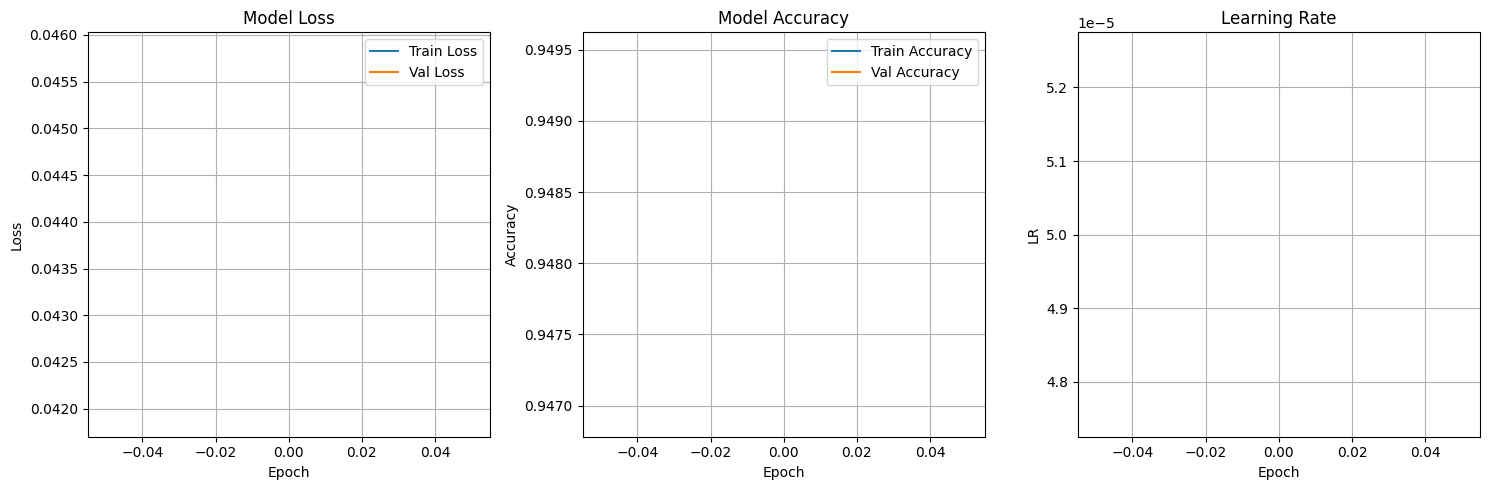

In [11]:
print("="*60)
print("TRAINING PLOTS")
print("="*60)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'] if 'lr' in history.history else [CONFIG["learning_rate"]] * CONFIG["epochs"])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('Epoch')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_history.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved: {os.path.join(output_dir, 'training_history.png')}")
plt.show()

## Test Set Evaluation

In [12]:
print("="*60)
print("TEST SET EVALUATION")
print("="*60)

# Load best weights
model.load_weights(os.path.join(output_dir, 'best_weights.weights.h5'))
print("✓ Loaded best weights")

# Get predictions
test_gen.reset()
pred_y = model.predict(test_gen, steps=len(test_gen), verbose=1)
pred_y = pred_y[:len(test_gen.labels)]  # Trim to exact length

# Get true labels
y_true = test_gen.labels

print(f"\nPredictions shape: {pred_y.shape}")
print(f"True labels shape: {y_true.shape}")

TEST SET EVALUATION
✓ Loaded best weights
288/288 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step

Predictions shape: (2299, 14)
True labels shape: (2299, 14)


## Optimal Thresholds

**DannyNet Improvement:** Find optimal F1 threshold for each disease independently.

In [13]:
print("="*60)
print("OPTIMAL THRESHOLDS (DannyNet approach)")
print("="*60)

optimal_thresholds = []
for i, disease in enumerate(all_labels):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], pred_y[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
    optimal_thresholds.append(best_threshold)
    print(f"{disease:25s} Optimal Threshold: {best_threshold:.3f}")

OPTIMAL THRESHOLDS (DannyNet approach)
Atelectasis               Optimal Threshold: 0.396
Cardiomegaly              Optimal Threshold: 0.353
Consolidation             Optimal Threshold: 0.333
Edema                     Optimal Threshold: 0.355
Effusion                  Optimal Threshold: 0.438
Emphysema                 Optimal Threshold: 0.291
Fibrosis                  Optimal Threshold: 0.297
Hernia                    Optimal Threshold: 0.216
Infiltration              Optimal Threshold: 0.399
Mass                      Optimal Threshold: 0.408
Nodule                    Optimal Threshold: 0.290
Pleural_Thickening        Optimal Threshold: 0.335
Pneumonia                 Optimal Threshold: 0.264
Pneumothorax              Optimal Threshold: 0.390


## Per-Disease Metrics

In [14]:
print("="*60)
print("PER-DISEASE METRICS")
print("="*60)

auc_scores = []
f1_scores_list = []

for i, disease in enumerate(all_labels):
    # AUC
    try:
        auc_score = roc_auc_score(y_true[:, i], pred_y[:, i])
    except:
        auc_score = 0.0
    auc_scores.append(auc_score)

    # F1 with optimal threshold
    pred_binary = (pred_y[:, i] > optimal_thresholds[i]).astype(int)
    f1 = f1_score(y_true[:, i], pred_binary)
    f1_scores_list.append(f1)

    print(f"{disease:25s} AUC: {auc_score:.4f} | F1: {f1:.4f}")

avg_auc = np.mean(auc_scores)
avg_f1 = np.mean(f1_scores_list)

print("\n" + "="*60)
print(f"AVERAGE AUC: {avg_auc:.4f}")
print(f"AVERAGE F1:  {avg_f1:.4f}")
print("="*60)

PER-DISEASE METRICS
Atelectasis               AUC: 0.7571 | F1: 0.3311
Cardiomegaly              AUC: 0.9137 | F1: 0.4337
Consolidation             AUC: 0.7691 | F1: 0.2326
Edema                     AUC: 0.8459 | F1: 0.2430
Effusion                  AUC: 0.8810 | F1: 0.5609
Emphysema                 AUC: 0.9293 | F1: 0.4457
Fibrosis                  AUC: 0.7687 | F1: 0.0909
Hernia                    AUC: 0.9639 | F1: 0.1538
Infiltration              AUC: 0.6747 | F1: 0.3763
Mass                      AUC: 0.8512 | F1: 0.4175
Nodule                    AUC: 0.6944 | F1: 0.2289
Pleural_Thickening        AUC: 0.7626 | F1: 0.2787
Pneumonia                 AUC: 0.6485 | F1: 0.0370
Pneumothorax              AUC: 0.8558 | F1: 0.3219

AVERAGE AUC: 0.8083
AVERAGE F1:  0.2966


## ROC Curves


Generating ROC curves...
✓ Saved: ./roc_curves.png


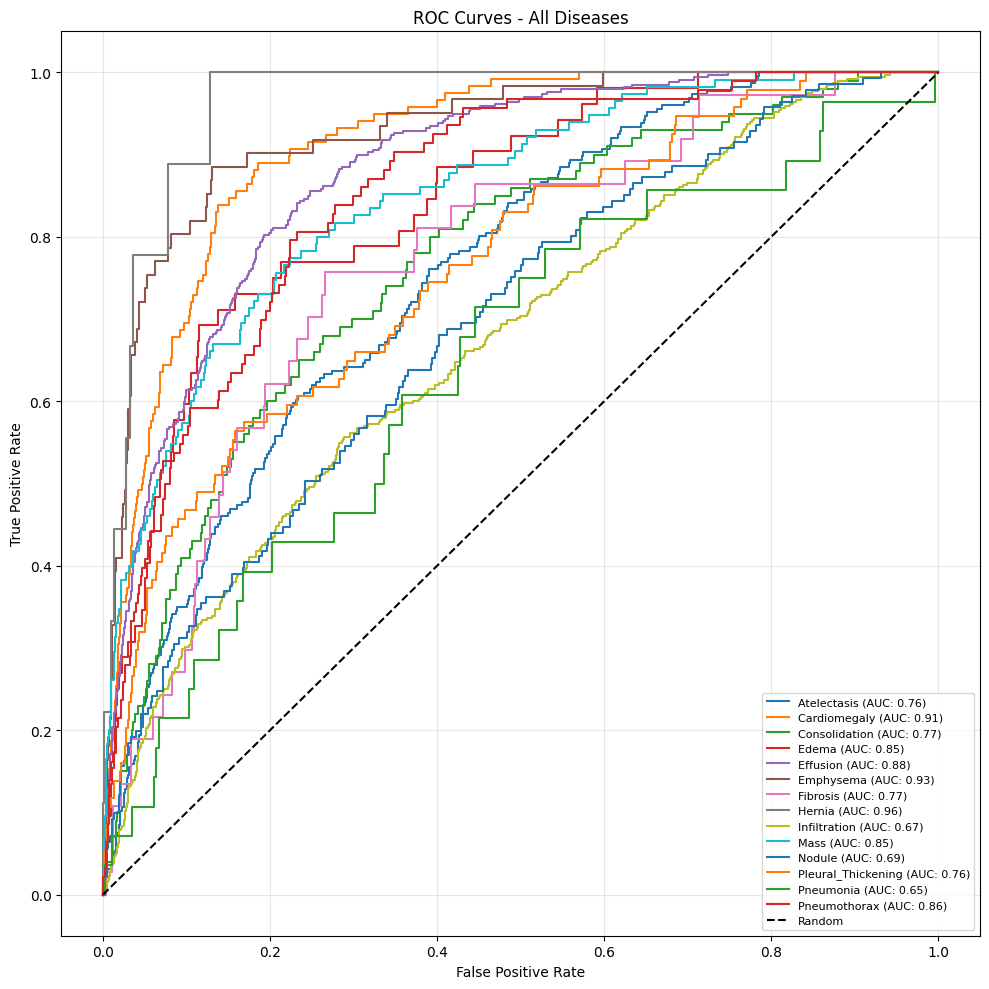

In [15]:
print("\nGenerating ROC curves...")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, disease in enumerate(all_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i].astype(int), pred_y[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{disease} (AUC: {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - All Diseases')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curves.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved: {os.path.join(output_dir, 'roc_curves.png')}")
plt.show()

## Visualize Predictions


Visualizing predictions...
✓ Saved: ./sample_predictions.png


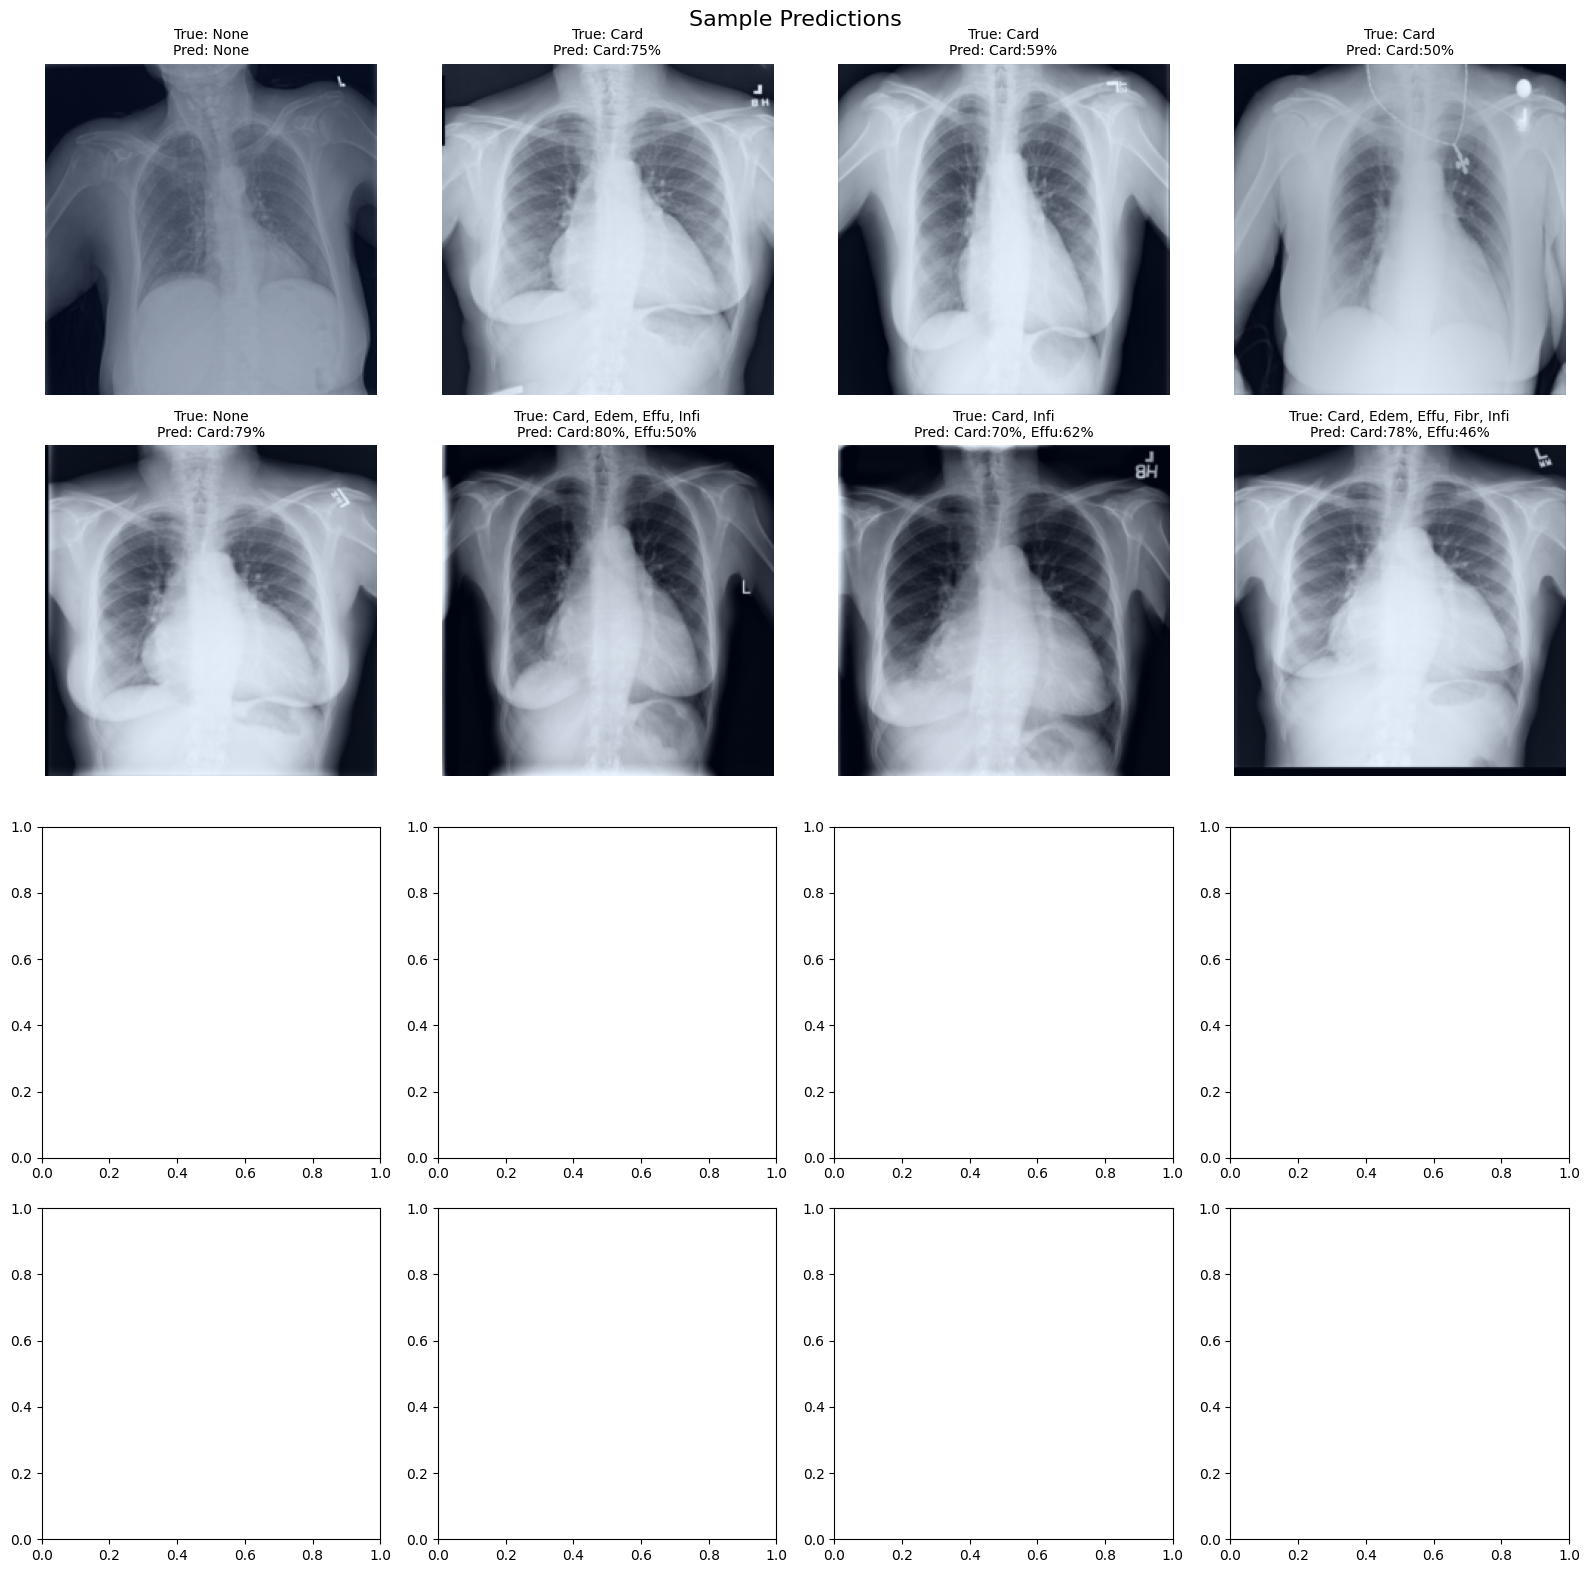


ALL DONE!
Output files saved to: ./
Files:
  - best_weights.weights.h5
  - training_history.png
  - roc_curves.png
  - sample_predictions.png


In [16]:
print("\nVisualizing predictions...")

test_gen.reset()
test_x, test_y = next(test_gen)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Sample Predictions', fontsize=16)

for idx, ax in enumerate(axes.flatten()):
    if idx >= len(test_x):
        break

    # Show image
    img = test_x[idx]
    # Denormalize for display
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)

    # Get true labels
    true_diseases = [all_labels[i] for i in range(len(all_labels)) if test_y[idx, i] > 0.5]

    # Get predicted labels (with optimal thresholds)
    pred_diseases = [(all_labels[i], pred_y[idx, i])
                     for i in range(len(all_labels))
                     if pred_y[idx, i] > optimal_thresholds[i]]

    # Format predictions
    pred_str = [f"{d[:4]}:{p*100:.0f}%" for d, p in pred_diseases]

    title = f"True: {', '.join([d[:4] for d in true_diseases]) if true_diseases else 'None'}\n"
    title += f"Pred: {', '.join(pred_str) if pred_str else 'None'}"

    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved: {os.path.join(output_dir, 'sample_predictions.png')}")
plt.show()

print("\n" + "="*60)
print("ALL DONE!")
print("="*60)
print(f"Output files saved to: {output_dir}")
print("Files:")
print("  - best_weights.weights.h5")
print("  - training_history.png")
print("  - roc_curves.png")
print("  - sample_predictions.png")
print("="*60)